# Part 3 : Would players be better now ?

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from urllib.parse import unquote

import wikipediaapi # need python 3.9 or higher to work
from time import sleep

import networkx as nx
from scipy import stats

from node2vec import Node2Vec
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity

c:\Users\Anasse\miniconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ARTICLE_TXT_PATH = os.path.join('data', '2007', 'plaintext_articles')
PATH_2007 = os.path.join('data', '2007')
PATH_2024 = os.path.join('data', '2024')

links2007 = pd.read_csv(os.path.join(PATH_2007, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
links2024 = pd.read_csv(os.path.join(PATH_2024, 'links2024.csv'))
links2024 = links2024.drop_duplicates().reset_index(drop=True)

## Study of the players path

### Path unfinished

Let's determine whether an unfinished path in 2007 could have been completed back then (i.e., if the player was close to reaching the target) and compare it to the 2024 Wikipedia link structure to assess if the player could now finish the game more quickly in 2024 than in 2007.

In [3]:
path_unfinished = pd.read_csv(os.path.join(PATH_2007, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], usecols=['hashedIpAddress', 'durationInSec', 'path', 'target', 'type'])

In [79]:
# remove path with only one element -> not considered as an attempt
# get path length
path_unfinished['path_length'] = path_unfinished['path'].apply(lambda x: len(x.split(';')))
path_unfinished = path_unfinished[path_unfinished['path_length'] > 3]
path_unfinished.head()

,hashedIpAddress,durationInSec,path,target,type,path_length
5,131600803df4895e,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,4
6,486bb79910fe9dd2,1932,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,timeout,7
7,6d136e371e42474f,175,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,restart,5
9,6d136e371e42474f,2006,Logic;Computer_science;Science;Physical_scienc...,Moon_landing,timeout,9
10,430ca00e7f5303b7,1976,Battle_of_Gettysburg;Washington%2C_D.C.;United...,Ostrich,timeout,7


In [78]:
path_unfinished.describe()['path_length']

count    13273.000000
mean         8.147367
std          6.571635
min          4.000000
25%          5.000000
50%          6.000000
75%          9.000000
max        235.000000
Name: path_length, dtype: float64

Let's process our unfinished path to determine whether, theoretically, a player could have completed the game in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [6]:
def fix_path(path):
    """
    Fix the path by removing the last element if it is '<'
    """
    path_elements = path.split(';')
    result_stack = []

    for element in path_elements:
        if element == '<':
            if result_stack:  # Remove the last element only if the stack is not empty
                result_stack.pop()
        else:
            result_stack.append(element)
    return result_stack


def check_if_link_exists(row, links):
    """
    Check if in the path of the row, there is a faster way to reach the target
    Also, check if the path is valid
    """
    path_list = fix_path(row['path'])
    # Convert list to a set for quick lookup and calculate target links
    path_set = set(path_list)
    target = row['target']
    
    # Filter links2024 to get only relevant links with target linkSource in path
    last_links = set(links.loc[links['linkTarget'] == target, 'linkSource'])
    intersecting_links = path_set.intersection(last_links)
    
    if intersecting_links:
        # Verify that each path[i+1] exists in the linkTarget of path[i]
        for i in range(len(path_list) - 1):
            current_node = path_list[i]
            next_node = path_list[i + 1]
            # Check if next_node is in linkTarget of current_node in links2024
            if not ((links['linkSource'] == current_node) & (links['linkTarget'] == next_node)).any():
                return None, -1  # Return None, -1 if the link is invalid
        
        # Find the index of the first occurrence in path_list
        index = next((i for i, link in enumerate(path_list) if link in intersecting_links), None)
        return path_list[index], len(path_list) - index - 1
    else:
        return path_list[-1], 0

In [7]:
# # create a dafaframe with columns 'path', 'target', 'final_link2007', 'final_link2024', 'distance2007', 'distance2024'
# df_unfinished = []

# for i, data in tqdm(path_unfinished.iterrows(), total=len(path_unfinished), desc='Processing data'):
#     output_link, distance = check_if_link_exists(data, links2007)
#     output_link2, distance2 = check_if_link_exists(data, links2024)

#     # add the data to the output dataframe
#     df_unfinished.append({'path': data['path'], 'target': data['target'], 'final_link2007': output_link, 'final_link2024': output_link2, 'distance2007': distance, 'distance2024': distance2})
    
# df_unfinished = pd.DataFrame(df_unfinished)

# save df_unfinished to a csv file
# df_unfinished.to_csv(os.path.join(PATH_2007, 'comparison_unfinished_to_2024.csv'), index=False)

df_unfinished = pd.read_csv(os.path.join(PATH_2007, 'comparison_unfinished_to_2024.csv'))

In [8]:
print(df_unfinished.shape)
df_unfinished.head()

(19661, 6)


,path,target,final_link2007,final_link2024,distance2007,distance2024
0,Malawi;Democracy;Alexander_the_Great,First_Crusade,Alexander_the_Great,Alexander_the_Great,0,0
1,Paraguay;Bolivia,Mount_St._Helens,Bolivia,Bolivia,0,0
2,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,Yangtze_River,NaN,0,-1
3,Mind;Christianity;Europe;Renaissance;Ancient_G...,Scouting,Asia,Asia,0,0
4,4-2-0;United_States;Agriculture;Sugar;Australia,Cane_Toad,Australia,Australia,0,0


In [9]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_unfinished[(df_unfinished['distance2007'] != -1) &
                       (df_unfinished['distance2024'] != -1)]

In [10]:
df_ttest.describe()

,distance2007,distance2024
count,15335.000000,15335.000000
mean,0.065145,0.056798
std,0.732249,0.376145
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,61.000000,12.000000


In [11]:
stats.ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=1.2556186478097844, pvalue=0.20926383333528778, df=30668.0)

interpretation: ??

In [12]:
print("==== Path possible ? ====")

print(f"Path won't change between 2007 and 2024 : {len(df_unfinished[(df_unfinished.distance2007 == 0) & (df_unfinished.distance2024 == 0)])}")
print(f"Path impossible to do in 2024 but possible in 2007 : {len(df_unfinished[(df_unfinished.distance2007 >= 0) & (df_unfinished.distance2024 == -1)])}")
print(f"Path impossible to do in 2007 and 2024 : {len(df_unfinished[(df_unfinished.distance2007 == -1) & (df_unfinished.distance2024 == -1)])}")
print(f"Path still possible in 2024 : {len(df_unfinished[(df_unfinished.distance2007 >= 0) & (df_unfinished.distance2024 >= 0)])}")

print()
print("==== Path faster or slower in 2024 ? ====")
print(f"Path faster in 2024 than 2007: {len(df_unfinished[df_unfinished.distance2007 < df_unfinished.distance2024])}")
print(f"Path slower or equal in 2024 than 2007: {len(df_unfinished[(df_unfinished.distance2007 >= df_unfinished.distance2024) & (df_unfinished.distance2024 >= 0) & (df_unfinished.distance2007 > 0)])}")

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14537
Path impossible to do in 2024 but possible in 2007 : 4324
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 15335

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 423
Path slower or equal in 2024 than 2007: 375


-> Find a better wawy to represent this above

Path not possible in 2007 ? This is strange... let's make more analysis

In [13]:
for i, data in df_unfinished[df_unfinished.distance2007 == -1].iterrows():
    testpath = fix_path(data['path'])

    for i in range(len(testpath) - 1):
        output = links2007[ (links2007.linkSource == testpath[i]) & (links2007.linkTarget == testpath[i+1])]
        if output.empty:
            print(f'Link {unquote(testpath[i])} -> {unquote(testpath[i+1])} does not exist in links2007')

Link Finland -> Åland does not exist in links2007
Link Technology -> Wikipedia_Text_of_the_GNU_Free_Documentation_License does not exist in links2007


By examining the Wikispeedia page for [Finland](https://dlab.epfl.ch/wikispeedia/play/?article=Finland), we can confirm the presence of a link to Åland. Same for Technology to Wikipedia_Text_of_the_GNU_Free_Documentation_License... 

However, these links are missing in our dataset `links2007`.

### Path finished

In [81]:
path_finished = pd.read_csv(os.path.join(PATH_2007, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_finished['target'] = path_finished['path'].apply(lambda x: x.split(';')[-1])
path_finished['path_length'] = path_finished['path'].apply(lambda x: len(x.split(';')))
path_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,path_length
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,9
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,5
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,8
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,4
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,7


In [82]:
path_finished.describe()['path_length']

count    51318.000000
mean         6.757434
std          4.680718
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64

Let's check if the rating difficulty of the game is correlated with the number of clicks needed to finish the game. I drop the NaN values instead of imputing them to have an unbiased result for the correlation.

In [15]:
stats.pearsonr(path_finished.dropna(subset=['rating'])['path_length'], 
               path_finished.dropna(subset=['rating'])['rating'])

PearsonRResult(statistic=0.4037485699951062, pvalue=0.0)

In [16]:
stats.spearmanr(path_finished.dropna(subset=['rating'])['path_length'], 
                path_finished.dropna(subset=['rating'])['rating'])

SignificanceResult(statistic=0.5539921093665069, pvalue=0.0)

Significant correlation between the path length and rating of the player.

Let's process our finished path to determine whether, theoretically, a player could have completed the game earlier in 2007 and to analyze whether finishing the game is faster in 2024 compared to 2007.

Data format:
| path | target | final_link | distance |
|------|--------|------------|----------|
|path of the player      |   target to reach     |      final link reached before going to target (same as path if target cannot be reached)      |     number of click earned (equal -1 if the path is not possible based on our data)    |

In [17]:
def check_if_link_exists_finished(row, links):
    path_list = fix_path(row['path'])
    if len(path_list) > 1:
        target = row['target']
        path_list.remove(target)
        
        # Convert list to a set for quick lookup and calculate target links
        path_set = set(path_list)
        
        # Filter links2024 to get only relevant links with target linkSource in path
        last_links = set(links.loc[links['linkTarget'] == target, 'linkSource'])
        intersecting_links = path_set.intersection(last_links)
        
        if intersecting_links:
            # Verify that each path[i+1] exists in the linkTarget of path[i]
            for i in range(len(path_list) - 1):
                current_node = path_list[i]
                next_node = path_list[i + 1]
                # Check if next_node is in linkTarget of current_node in links2024
                if not ((links['linkSource'] == current_node) & (links['linkTarget'] == next_node)).any():
                    return None, -1  # Return None, -1 if the link is invalid
            
            # Find the index of the first occurrence in path_list
            index = next((i for i, link in enumerate(path_list) if link in intersecting_links), None)
            return path_list[index], len(path_list) - index - 1
        else:
            return path_list[-1], 0
    else:
        return path_list[0], 0

In [18]:
# df_finished = []

# for i, data in tqdm(path_finished.iterrows(), total=len(path_finished), desc='Processing data'):
#     subdata = data[['path', 'target']]
#     output_link, distance = check_if_link_exists_finished(subdata, links2007)
#     output_link2, distance2 = check_if_link_exists_finished(subdata, links2024)

#     # add the data to the output dataframe
#     df_finished.append({'path': data['path'], 'target': data['target'], 'final_link2007': output_link, 'final_link2024': output_link2, 'distance2007': distance, 'distance2024': distance2})

# df_finished = pd.DataFrame(df_finished)
# df_finished.to_csv(os.path.join(PATH_2007, 'comparison_finished_to_2024.csv'), index=False)

df_finished = pd.read_csv(os.path.join(PATH_2007, 'comparison_finished_to_2024.csv'))

In [19]:
# remove all path with distance = -1 (invalid path and no possible comparison)
df_ttest = df_finished[(df_finished['distance2007'] != -1) &
                       (df_finished['distance2024'] != -1)]

df_ttest.describe()

,distance2007,distance2024
count,18636.000000,18636.000000
mean,0.170745,0.294162
std,0.648322,0.733330
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,25.000000,27.000000


In [20]:
stats.ttest_ind(df_ttest['distance2007'], df_ttest['distance2024'])

TtestResult(statistic=-17.212631239901707, pvalue=3.8502960068475356e-66, df=37270.0)

pvalue < 0.05, we reject the null hypothesis that the two distributions have identical average expected value. 

In [21]:
print("==== Path possible ? ====")

print(f"Path won't change between 2007 and 2024 : {len(df_finished[(df_finished.distance2007 == 0) & (df_finished.distance2024 == 0)])}")
print(f"Path impossible to do in 2024 but possible in 2007 : {len(df_finished[(df_finished.distance2007 >= 0) & (df_finished.distance2024 == -1)])}")
print(f"Path impossible to do in 2007 and 2024 : {len(df_finished[(df_finished.distance2007 == -1) & (df_finished.distance2024 == -1)])}")
print(f"Path still possible in 2024 : {len(df_finished[(df_finished.distance2007 >= 0) & (df_finished.distance2024 >= 0)])}")

print()
print("==== Path faster or slower in 2024 ? ====")
print(f"Path faster in 2024 than 2007: {len(df_finished[df_finished.distance2007 < df_finished.distance2024])}")
print(f"Path slower or equal in 2024 than 2007: {len(df_finished[(df_finished.distance2007 >= df_finished.distance2024) & (df_finished.distance2024 >= 0) & (df_finished.distance2007 > 0)])}")

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14020
Path impossible to do in 2024 but possible in 2007 : 32677
Path impossible to do in 2007 and 2024 : 2
Path still possible in 2024 : 18636

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 2719
Path slower or equal in 2024 than 2007: 1900


## Is the structure of Wikipedia 2024 more efficient than 2007 ?

In [22]:
articles = pd.read_csv(os.path.join(PATH_2007, 'articles.tsv'), sep='\t', comment='#', names=['article'])

links2007_unquote = links2007.copy()
links2007_unquote['linkSource'] = links2007_unquote['linkSource'].apply(unquote)
links2007_unquote['linkTarget'] = links2007_unquote['linkTarget'].apply(unquote)

links2024_unquote = links2024.copy()
links2024_unquote['linkSource'] = links2024_unquote['linkSource'].apply(unquote)
links2024_unquote['linkTarget'] = links2024_unquote['linkTarget'].apply(unquote)

common_article = set(links2007_unquote['linkSource']).intersection(set(links2024_unquote['linkSource']))

In [23]:
# create a graph with links dataframe
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(articles['article'].apply(unquote))

for i, row in links2007_unquote.iterrows():
    if row['linkSource'] in G_2007.nodes and row['linkTarget'] in G_2007.nodes:
        G_2007.add_edge(row['linkSource'], row['linkTarget'])  

In [24]:
G_2024 = nx.DiGraph()
G_2024.add_nodes_from(articles['article'].apply(unquote))

for i, row in links2024_unquote.iterrows():
    if row['linkSource'] in G_2024.nodes and row['linkTarget'] in G_2024.nodes:
        G_2024.add_edge(row['linkSource'], row['linkTarget'])

### Similarity

How can we compare the efficiency of Wikipedia's structure in 2007 and 2024?

One approach is to evaluate the similarity between articles. For each article, we calculate its similarity with every other article. Then, we compute a similarity score for each article, which corresponds to the average similarity with all the articles it links to (outgoing links).

<!-- ecrit une formule en latex pour expliquer ce que je dis plus haut -->

$$ \text{similarity score}(article) = \frac{1}{n} \sum_{i=1}^{n} \text{similarity}(article, article_i) $$

where $n$ is the number of outgoing links of the article, and $article_i$ is the $i$-th article linked to by the article.

How compute the similarity between two articles? 

The main task is to find a way to represent articles in a vector space. we decide to use two differents approaches:

- `Node2Vec`: We use the node2vec algorithm to compute the similarity between articles. Node2Vec is an algorithm that learns continuous feature representations for nodes in networks. We use the node2vec implementation from the `node2vec` library.

- `Sentence-BERT`: We use the Sentence-BERT model to represent article content in a vector space. Sentence-BERT is a modification of the BERT network that is trained to derive semantically meaningful sentence embeddings. We use the `sentence-transformers` library to compute the similarity between articles.

Node2vec focus more on the structure of the graph, while Sentence-BERT focus more on the content of the articles.

Then, our similarity score is the average of the similarity scores obtained with the two methods.

$$ \text{similarity}(a_1, a_2) = \frac{1}{2} \left( \text{similarity}(a_1, a_2)_{\text{Node2Vec}} + \text{similarity}(a_1, a_2)_{\text{Sentence-BERT}} \right) $$

where $a_1$ and $a_2$ are two articles.

#### Node2Vec

In [25]:
# node2vec_2007 = Node2Vec(G_2007, dimensions=64, walk_length=30, num_walks=200, workers=1)
# model_2007 = node2vec_2007.fit(window=10, min_count=1, batch_words=4)

# node2vec_2024 = Node2Vec(G_2024, dimensions=64, walk_length=30, num_walks=200, workers=1)
# model_2024 = node2vec_2024.fit(window=10, min_count=1, batch_words=4)

# # Save the model
# model_2007.save(os.path.join(PATH_2007, 'node2vec_2007.model'))
# model_2024.save(os.path.join(PATH_2024, 'node2vec_2024.model'))

# Load the model
model_2007 = Word2Vec.load('node2vec_2007.model')
model_2024 = Word2Vec.load('node2vec_2024.model')

In [26]:
n2v_embeddings_2007 = {node: model_2007.wv[node] for node in G_2007.nodes()}
n2v_embeddings_2024 = {node: model_2024.wv[node] for node in G_2024.nodes()}

In [27]:
n2v_cosine_similarities_2007 = cosine_similarity(np.array(list(n2v_embeddings_2007.values())))
n2v_cosine_similarities_2024 = cosine_similarity(np.array(list(n2v_embeddings_2024.values())))

In [28]:
links2007_unquote['n2v_similarity'] = links2007_unquote.apply(lambda x: n2v_cosine_similarities_2007[list(G_2007.nodes()).index(x['linkSource']),
                                                                                     list(G_2007.nodes()).index(x['linkTarget'])], axis=1)

links2024_unquote['n2v_similarity'] = links2024_unquote.apply(lambda x: n2v_cosine_similarities_2024[list(G_2024.nodes()).index(x['linkSource']), 
                                                                                     list(G_2024.nodes()).index(x['linkTarget'])], axis=1)

#### Sentence-BERT

First, we need to get the article content from wikipedia (only summary). 

- 2007 : We use the plaintext_articles data to get the content of the articles.

- 2024 : We use the Wikipedia API to get the content of the articles.

##### 2007

In [33]:
def extract_first_paragraph(text):
    # Split the text by new lines
    lines = text.split('\n')

    # ignore the 5 first lines
    lines = lines[5:]

    # while a line don't begin by "   ", remove it
    while lines[0][:3] != "   ":
        lines = lines[1:]

    # List to accumulate lines of the first paragraph
    paragraph_lines = []
    paragraph_started = False

    for l in lines:
        if l[:3] == "   " or not l:
            paragraph_started = True
            paragraph_lines.append(l)
        elif paragraph_started:
            break

    # Join the lines to form the paragraph
    paragraph = '\n'.join(paragraph_lines)

    # return paragraph
    return paragraph

In [34]:
summaries2007 = {'article' : [], 'content' : []}

for filename in tqdm(os.listdir(ARTICLE_TXT_PATH)):
    with open(os.path.join(ARTICLE_TXT_PATH, filename), 'r', encoding='utf8') as f:
        text = f.read() 

    paragraph = extract_first_paragraph(text)
    summaries2007['article'].append(unquote(filename[:-4]))
    summaries2007['content'].append(paragraph.strip())

summaries2007 = pd.DataFrame(summaries2007)
summaries2007.to_csv(os.path.join('data', '2007', 'summaries2007.csv'), index=False, encoding='utf8')

100%|██████████| 4604/4604 [00:01<00:00, 4383.57it/s]


In [35]:
summaries2007.head()

,article,content
0,Áedán_mac_Gabráin,Satellite image of northern Britain and Irelan...
1,Åland,Landskapet Åland\n Ahvenanmaan maakunta\n ...
2,Édouard_Manet,Articles with similar titles include Claude Mo...
3,Éire,This is a featured article. Click here for mor...
4,Óengus_I_of_the_Picts,Óengus son of Fergus\n King of the Picts\n ...


##### 2024

In [36]:
# wiki_wiki = wikipediaapi.Wikipedia('ada (anasse.elboudiri@epfl.ch)', 'en')

# summaries2024 = {'article' : [], 'content' : []}

# for article in articles['article']:
#     page = wiki_wiki.page(article)
#     if page.exists():
#         summaries2024['article'].append(article)
#         summaries2024['content'].append(page.summary)
#     sleep(0.1)

# # article names that are different in 2007 and 2024
# old_names = ["Athletics_%28track_and_field%29",
#              "Bionicle__Mask_of_Light",
#              "Directdebit",
#              "Newshounds",
#              "Star_Wars_Episode_IV__A_New_Hope",
#              "Wikipedia_Text_of_the_GNU_Free_Documentation_License",
#              "X-Men__The_Last_Stand"]

# new_names = ["Track_and_field",
#             "Bionicle:_Mask_of_Light",
#             "Direct_debit",
#             "News_Hounds",
#             "Star_Wars_(film)",
#             "Wikipedia:Text_of_the_GNU_Free_Documentation_License",
#             "X-Men:_The_Last_Stand"]

# for old, new in zip(old_names, new_names):
#     page = wiki_wiki.page(new)
#     if page.exists():
#         summaries2024['article'].append(unquote(old))
#         summaries2024['content'].append(page.summary)
    
# summaries2024 = pd.DataFrame(summaries2024)
# summaries2024.to_csv(os.path.join('data', '2024', 'summaries2024.csv'), index=False, encoding='utf-8')

summaries2024 = pd.read_csv(os.path.join('data', '2024', 'summaries2024.csv'), encoding='utf-8')
summaries2024.head()

,article,content
0,Áedán_mac_Gabráin,Áedán mac Gabráin (Old Irish pronunciation: [ˈ...
1,Åland,Åland (Swedish: [ˈǒːland] ; Finnish: Ahvenanma...
2,Édouard_Manet,"Édouard Manet (UK: , US: ; French: [edwaʁ manɛ..."
3,Éire,Éire (Irish: [ˈeːɾʲə] ) is the Irish Gaelic na...
4,Óengus_I_of_the_Picts,Óengus son of Fergus (Pictish: *Onuist map Vur...


##### SBERT

In [37]:
# Load the SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [38]:
sbert_embeddings_2007 = {article: model.encode(text) for article, text in zip(summaries2007['article'], summaries2007['content'])}
sbert_embeddings_2024 = {article: model.encode(text) for article, text in zip(summaries2024['article'], summaries2024['content'])}

In [39]:
sbert_cosine_similarities_2007 = cosine_similarity(np.array(list(sbert_embeddings_2007.values())))
sbert_cosine_similarities_2024 = cosine_similarity(np.array(list(sbert_embeddings_2024.values())))

In [41]:
links2007_unquote['sbert_similarity'] = links2007_unquote.apply(lambda x: sbert_cosine_similarities_2007[list(sbert_embeddings_2007.keys()).index(x['linkSource']),
                                                                                     list(sbert_embeddings_2007.keys()).index(x['linkTarget'])], axis=1)

links2024_unquote['sbert_similarity'] = links2024_unquote.apply(lambda x: sbert_cosine_similarities_2024[list(sbert_embeddings_2024.keys()).index(x['linkSource']), 
                                                                                     list(sbert_embeddings_2024.keys()).index(x['linkTarget'])], axis=1)

#### Analysis

In [42]:
links2007_unquote.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity
0,Áedán_mac_Gabráin,Bede,0.585006,0.237665
1,Áedán_mac_Gabráin,Columba,0.731949,0.429983
2,Áedán_mac_Gabráin,Dál_Riata,0.731973,0.650527
3,Áedán_mac_Gabráin,Great_Britain,0.655600,0.170070
4,Áedán_mac_Gabráin,Ireland,0.656894,0.342100


In [43]:
links2024_unquote.head()

,linkSource,linkTarget,n2v_similarity,sbert_similarity
0,Áedán_mac_Gabráin,Dál_Riata,0.881055,0.550869
1,Áedán_mac_Gabráin,Columba,0.760585,0.457233
2,Áedán_mac_Gabráin,Orkney,0.744174,0.278360
3,Áedán_mac_Gabráin,Isle_of_Man,0.568829,0.396943
4,Áedán_mac_Gabráin,Bede,0.586326,0.274804


In [55]:
similarity_2007 = links2007_unquote.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()
similarity_2024 = links2024_unquote.groupby('linkSource')[['n2v_similarity', 'sbert_similarity']].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,n2v_similarity_2007,sbert_similarity_2007,n2v_similarity_2024,sbert_similarity_2024
count,4539.000000,4539.000000,4539.000000,4539.000000
mean,0.539606,0.225459,0.565896,0.239078
std,0.120540,0.102761,0.122095,0.087992
min,0.234105,-0.133736,-0.024988,-0.095537
25%,0.450327,0.154362,0.479622,0.180471
50%,0.522074,0.215350,0.551837,0.237080
75%,0.617628,0.284711,0.640586,0.294082
max,0.991188,0.688811,0.947322,0.628260


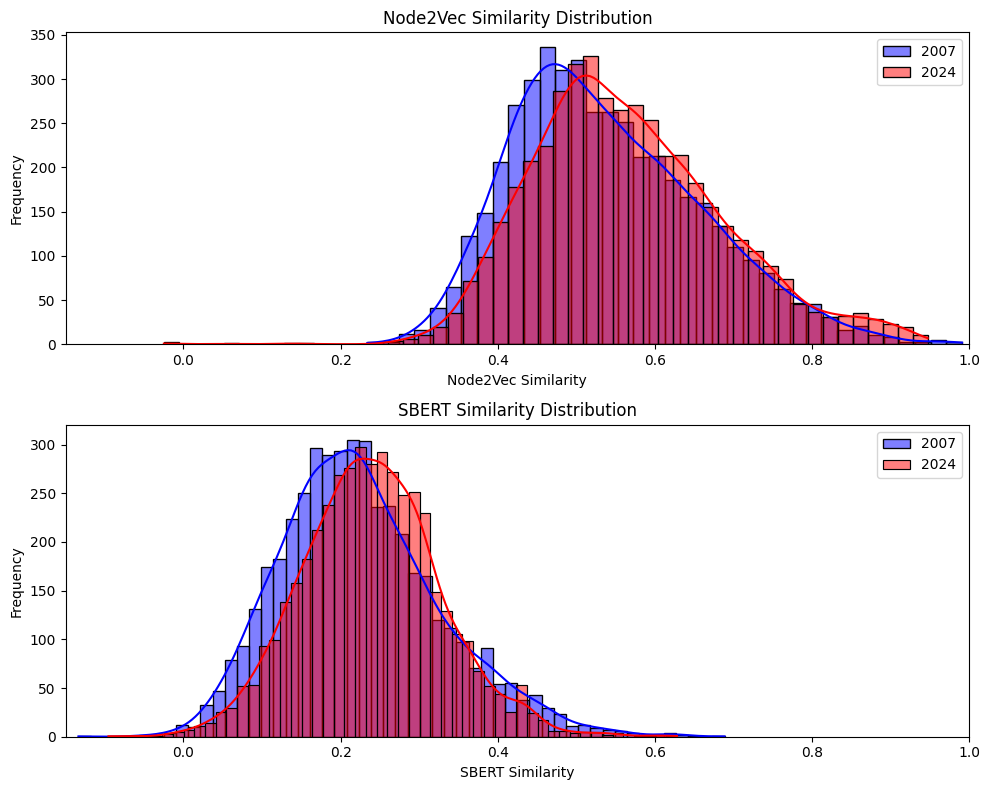

In [71]:
# plot 2subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(similarities['n2v_similarity_2007'], ax=axs[0], color='blue', kde=True, label='2007')
sns.histplot(similarities['n2v_similarity_2024'], ax=axs[0], color='red', kde=True, label='2024')
axs[0].set_title('Node2Vec Similarity Distribution')
axs[0].set_xlabel('Node2Vec Similarity')
axs[0].set_ylabel('Frequency')
axs[0].legend()

sns.histplot(similarities['sbert_similarity_2007'], ax=axs[1], color='blue', kde=True, label='2007')
sns.histplot(similarities['sbert_similarity_2024'], ax=axs[1], color='red', kde=True, label='2024')
axs[1].set_title('SBERT Similarity Distribution')
axs[1].set_xlabel('SBERT Similarity')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# set x and y limits
axs[0].set_xlim(-0.15, 1)
axs[1].set_xlim(-0.15, 1)
plt.tight_layout()
plt.show()

In [73]:
links2007_unquote['similarity'] = links2007_unquote.apply(lambda x: np.mean([x['n2v_similarity'], x['sbert_similarity']]), axis=1)
links2024_unquote['similarity'] = links2024_unquote.apply(lambda x: np.mean([x['n2v_similarity'], x['sbert_similarity']]), axis=1)

In [74]:
similarity_2007 = links2007_unquote.groupby('linkSource')['similarity'].mean()
similarity_2024 = links2024_unquote.groupby('linkSource')['similarity'].mean()

similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', suffixes=('_2007', '_2024'))
similarities.describe()

,similarity_2007,similarity_2024
count,4539.000000,4539.000000
mean,0.382532,0.402487
std,0.102174,0.094681
min,0.104964,-0.020964
25%,0.309238,0.337917
50%,0.367312,0.394595
75%,0.447471,0.458558
max,0.828664,0.752633


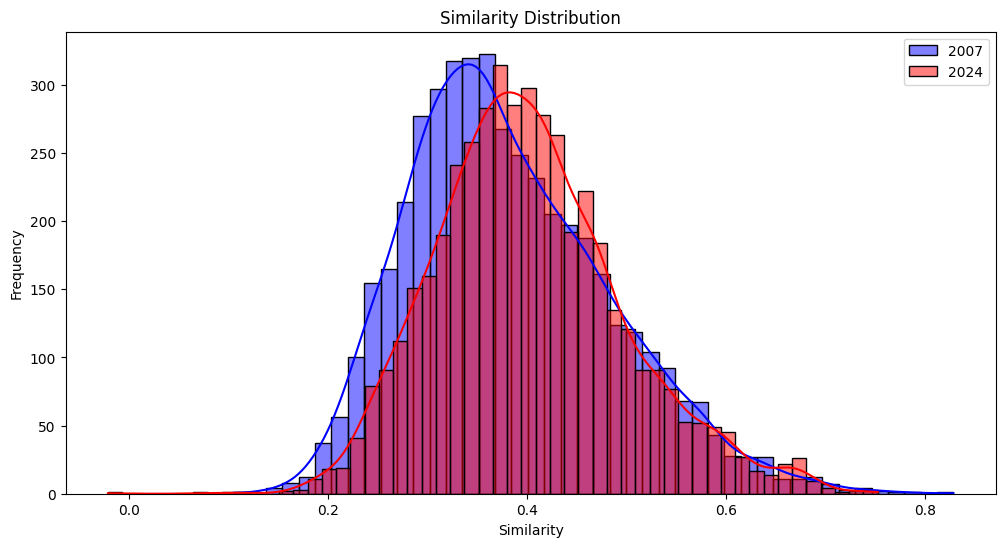

In [76]:
plt.figure(figsize=(12, 6))
sns.histplot(similarities['similarity_2007'], kde=True, color='blue', label='2007')
sns.histplot(similarities['similarity_2024'], kde=True, color='red', label='2024')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution')
plt.legend()
plt.show()